In [2]:
import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from typing import Optional, List
from torchdyn.core import NeuralODE
import os
import scipy.io as sio


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.models.lit_encoder import LitDistEncoder
from src.data.make_dataset import train_dataloader
from src.data.make_dataset import make_n_sphere_two
from src.data.make_dataset import make_tree
from src.data.make_dataset import make_live_seq
from src.data.make_dataset import make_pbmc
from src.data.make_dataset import make_ipsc
from src.fim_noemb import FIM
from src.fim_noemb import FIM_torch
from src.fim_noemb import FIM_cpu
import os
from sklearn.decomposition import PCA
import math
import random
import pickle

import h5py
import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn
import random
from src.models.lit_node import NODE, ToyODE

# NOTE: NeuralODE runs on CPU so FIM computations should be done on CPU

In [3]:
#load data
initdir = os.getcwd()
os.chdir(os.path.abspath('..') + '/src/data')
X = sio.loadmat('ipscData.mat')['data']
os.chdir(initdir)

In [4]:
#Define model

# Data Parameters
dataset = "ipsc"
n_obs = 1500
n_dim = X.shape[1]
batch_size = 50

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "ipsc_phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 5 # PHATE kernel number of Nearest Neighbors.
logp=False

# Trainer param
max_epochs = 150
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "ipsc_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

device = torch.device('cpu')
model_ipsc = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)




[Linear(in_features=33, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


In [5]:
#Load saved model
model_ipsc.load_state_dict(torch.load('saved_models/ipsc_model_1_25.pt',map_location=device))


<All keys matched successfully>

# Test FIM metric for one data point

In [6]:


n_obs=1500
nontrain = list(np.arange(X.shape[0]))
testind = random.sample(nontrain,n_obs)
ipsc_data, ipsc_phate = make_ipsc(n_obs=n_obs,emb_dim=2,knn=5,indx=testind)
fcn = model_ipsc.encode

#pred = model_ipsc.encode().detach().cpu().numpy()

def fisher_metric(x):
    y = model_ipsc.encode(x)
    fisher = FIM_cpu(x,fcn,1,n_dim,emb_dim,y)
    fishermat = fisher.fit()
    metric = torch.tensor(fishermat).cpu()
    return metric

x = ipsc_data[10,None,:]
print(x.shape)
check = fisher_metric(x)
print(check.get_device())
print(check.shape)

torch.Size([1, 33])
-1
torch.Size([1, 33, 33])


/tmp/ipykernel_27025/1667688917.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metric = torch.tensor(fishermat).cpu()


# Function Defintions for metric computation

In [8]:

def fisher_metric(x):
    y = model_ipsc.encode(x)
    fisher = FIM_cpu(x,fcn,1,n_dim,emb_dim,y)
    fishermat = fisher.fit()
    metric = torch.tensor(fishermat).cuda()
    return metric.cpu()

def sphere_metric(x):
    n = x.shape[0]
    theta, phi = x[:, 0], x[:, 1]

    metric = torch.zeros(n, 2, 2)
    metric[:, 0, 0] = 1
    metric[:, 1, 1] = torch.sin(theta) ** 2
    return metric

def euc_metric(x):
    n = x.shape[0]
    metric = torch.zeros(n, 2, 2)
    metric[:, 0, 0] = 1.0
    metric[:, 1, 1] = 1.0
    return metric

def hyperb_metric(x):
    n = x.shape[0]
    mu, sigma2 = x[:,0], x[:,1]
    metric = torch.zeros(n, 2, 2)
    metric[:,0,0] = 1/sigma2
    metric[:,1,1] = 2/sigma2
    return metric


def polar_to_euc(mat):
    """mat (np.array): N X D
    N: number of observation in the path
    D: dimension (theta,psi)"""
    N, D = mat.shape
    coor = np.empty((N, 3))
    for i in range(N):
        theta, psi = mat[i, :]
        coor[i, :] = (
            np.sin(theta) * np.cos(psi),
            np.sin(theta) * np.sin(psi),
            np.cos(theta),
        )

    return coor


def euc_to_polar(mat):
    """mat (np.array) N X 3 return the corresponding polar coordinates."""
    N, _ = mat.shape
    coor = np.empty((N, 2))
    for i in range(N):
        x, y, z = mat[i, :]
        coor[i, :] = (np.arctan((np.sqrt(x**2 + y**2) / z)), np.arctan(y / x))
    return coor


def great_circle(x0, x1, omega):
    """Great circle passing by `x0` and `x1`."""
    u = x0
    w = np.cross(x0, x1)
    w = w / np.linalg.norm(w)
    v = np.cross(u, w)

    return u * np.cos(omega) + v * np.sin(omega)


def path_interval(path):
    theta_min = 0 <= path[:, 0].min()
    theta_max = path[:, 0].max() <= pi
    theta = theta_min and theta_max
    psi_min = 0 <= path[:, 1].min()
    psi_max = path[:, 1].max() <= 2 * pi
    psi = psi_min and psi_max

    return theta, psi


from torch import nn

ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "selu": nn.SELU,
    "elu": nn.ELU,
    "lrelu": nn.LeakyReLU,
    "softplus": nn.Softplus,
}


class SimpleDenseNet(nn.Module):
    def __init__(
        self,
        input_size: int,
        target_size: int,
        activation: str,
        batch_norm: bool = True,
        hidden_dims: Optional[List[int]] = None,
    ):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [256, 256, 256]
        dims = [input_size, *hidden_dims, target_size]
        layers = []
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(dims[i + 1]))
            layers.append(ACTIVATION_MAP[activation]())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class TimeInvariantVelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim, target_size=dim, *args, **kwargs)

    def forward(self, t, x):
        """ignore t run model."""
        del t
        return self.model(x)


class VelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim + 1, target_size=dim, *args, **kwargs)

    def forward(self, t, x):
        """ignore t run model."""
        if t.dim() < 2:
            t = t.repeat(x.shape[0])[:, None]
        x = torch.cat([t, x], dim=-1)
        return self.model(x)


class Regularizer(nn.Module):
    def __init__(self):
        pass


def _batch_root_mean_squared(tensor):
    tensor = tensor.view(tensor.shape[0], -1)
    return torch.norm(tensor, p=2, dim=1) / tensor.shape[1] ** 0.5


class RegularizationFunc(nn.Module):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        """Outputs a batch of scaler regularizations."""
        raise NotImplementedError


class L1Reg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.mean(torch.abs(dx), dim=1)


class L2Reg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return _batch_root_mean_squared(dx)


class SphereReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, sphere_metric(x), dx)
    
class FIMReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, fisher_metric(x), dx)
    
class HyperReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, hyperb_metric(x), dx)

class EucReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, euc_metric(x), dx)


class SquaredL2Reg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        to_return = dx.view(dx.shape[0], -1)
        return torch.pow(torch.norm(to_return, p=2, dim=1), 2)


def _get_minibatch_jacobian(y, x, create_graph=True):
    """Computes the Jacobian of y wrt x assuming minibatch-mode.
    Args:
      y: (N, ...) with a total of D_y elements in ...
      x: (N, ...) with a total of D_x elements in ...
    Returns:
      The minibatch Jacobian matrix of shape (N, D_y, D_x)
    """
    # assert y.shape[0] == x.shape[0]
    y = y.view(y.shape[0], -1)

    # Compute Jacobian row by row.
    jac = []
    for j in range(y.shape[1]):
        dy_j_dx = torch.autograd.grad(
            y[:, j],
            x,
            torch.ones_like(y[:, j]),
            retain_graph=True,
            create_graph=create_graph,
        )[0]
        jac.append(torch.unsqueeze(dy_j_dx, -1))
    jac = torch.cat(jac, -1)
    return jac


class JacobianFrobeniusReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        if hasattr(context, "jac"):
            jac = context.jac
        else:
            jac = _get_minibatch_jacobian(dx, x)
            context.jac = jac
        jac = _get_minibatch_jacobian(dx, x)
        context.jac = jac
        return _batch_root_mean_squared(jac)


class JacobianDiagFrobeniusReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        if hasattr(context, "jac"):
            jac = context.jac
        else:
            jac = _get_minibatch_jacobian(dx, x)
            context.jac = jac
        diagonal = jac.view(jac.shape[0], -1)[
            :, :: jac.shape[1]
        ]  # assumes jac is minibatch square, ie. (N, M, M).
        return _batch_root_mean_squared(diagonal)


class JacobianOffDiagFrobeniusReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        if hasattr(context, "jac"):
            jac = context.jac
        else:
            jac = _get_minibatch_jacobian(dx, x)
            context.jac = jac
        diagonal = jac.view(jac.shape[0], -1)[
            :, :: jac.shape[1]
        ]  # assumes jac is minibatch square, ie. (N, M, M).
        ss_offdiag = torch.sum(jac.view(jac.shape[0], -1) ** 2, dim=1) - torch.sum(
            diagonal**2, dim=1
        )
        ms_offdiag = ss_offdiag / (diagonal.shape[1] * (diagonal.shape[1] - 1))
        return ms_offdiag


def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd."""
    trJ = 0.0
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(
            x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True
        )[0][:, i]
    return trJ


class CNFReg(RegularizationFunc):
    def __init__(self, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.trace_estimator = (
            trace_estimator if trace_estimator is not None else autograd_trace
        )
        self.noise_dist, self.noise = noise_dist, None

    def forward(self, t, x, dx, context):
        # TODO we could check if jac is in the context to speed up
        return -self.trace_estimator(dx, x, noise=self.noise)


class AugmentationModule(nn.Module):
    """Class orchestrating augmentations.
    Also establishes order.
    """

    def __init__(
        self,
        cnf_estimator: str = None,
        l1_reg: float = 0.0,
        l2_reg: float = 0.0,
        sphere_reg: float = 0.0,
        fim_reg: float = 0.0,
        euc_reg: float = 0.0,
        hyper_reg:float = 0.0,
        squared_l2_reg: float = 0.0,
        jacobian_frobenius_reg: float = 0.0,
        jacobian_diag_frobenius_reg: float = 0.0,
        jacobian_off_diag_frobenius_reg: float = 0.0,
    ) -> None:
        super().__init__()
        self.cnf_estimator = cnf_estimator
        names = []
        coeffs = []
        regs = []
        if cnf_estimator == "exact":
            names.append("log_prob")
            coeffs.append(1)
            regs.append(CNFReg(None, noise_dist=None))
        if l1_reg > 0.0:
            names.append("L1")
            coeffs.append(l1_reg)
            regs.append(L1Reg())
        if l2_reg > 0.0:
            names.append("L2")
            coeffs.append(l2_reg)
            regs.append(L2Reg())
        if sphere_reg > 0.0:
            names.append("Sphere metric")
            coeffs.append(sphere_reg)
            regs.append(SphereReg())
        if fim_reg > 0.0:
            names.append("FIM")
            coeffs.append(fim_reg)
            regs.append(FIMReg())
        if euc_reg > 0.0:
            names.append("Euclidean metric")
            coeffs.append(euc_reg)
            regs.append(EucReg())
        if hyper_reg > 0.0:
            names.append("Hyperbolic metric")
            coeffs.append(hyper_reg)
            regs.append(HyperReg())
        if squared_l2_reg > 0.0:
            names.append("squared_L2")
            coeffs.append(squared_l2_reg)
            regs.append(SquaredL2Reg())
        if jacobian_frobenius_reg > 0.0:
            names.append("jacobian_frobenius")
            coeffs.append(jacobian_frobenius_reg)
            regs.append(JacobianFrobeniusReg())
        if jacobian_diag_frobenius_reg > 0.0:
            names.append("jacobian_diag_frobenius")
            coeffs.append(jacobian_diag_frobenius_reg)
            regs.append(JacobianDiagFrobeniusReg())
        if jacobian_off_diag_frobenius_reg > 0.0:
            names.append("jacobian_off_diag_frobenius")
            coeffs.append(jacobian_off_diag_frobenius_reg)
            regs.append(JacobianOffDiagFrobeniusReg())
        self.names = names
        self.coeffs = torch.tensor(coeffs)
        self.regs = torch.nn.ModuleList(regs)
        assert len(self.coeffs) == len(self.regs)
        self.aug_dims = len(self.coeffs)
        self.augmenter = Augmenter(augment_idx=1, augment_dims=self.aug_dims)

    def forward(self, x):
        """Separates and adds together losses."""
        if self.cnf_estimator is None:
            aug, x = x[:, : self.aug_dims], x[:, self.aug_dims :]
            reg = aug * self.coeffs
            if self.aug_dims == 0:
                reg = torch.zeros(1).type_as(x)
            return reg, x
        delta_logprob, aug, x = x[:, :1], x[:, 1 : self.aug_dims], x[:, self.aug_dims :]
        reg = aug * self.coeffs[1:].to(aug)
        if self.aug_dims == 1:
            reg = torch.zeros(1).type_as(x)
        return delta_logprob, reg, x


class Augmenter(nn.Module):
    """Augmentation class. Can handle several types of augmentation strategies for Neural DEs.
    :param augment_dims: number of augmented dimensions to initialize
    :type augment_dims: int
    :param augment_idx: index of dimension to augment
    :type augment_idx: int
    :param augment_func: nn.Module applied to the input datasets of dimension `d` to determine the augmented initial condition of dimension `d + a`.
                        `a` is defined implicitly in `augment_func` e.g. augment_func=nn.Linear(2, 5) augments a 2 dimensional input with 3 additional dimensions.
    :type augment_func: nn.Module
    :param order: whether to augment before datasets [augmentation, x] or after [x, augmentation] along dimension `augment_idx`. Options: ('first', 'last')
    :type order: str
    """

    def __init__(
        self,
        augment_idx: int = 1,
        augment_dims: int = 5,
        augment_func=None,
        order="first",
    ):
        super().__init__()
        self.augment_dims, self.augment_idx, self.augment_func = (
            augment_dims,
            augment_idx,
            augment_func,
        )
        self.order = order

    def forward(self, x: torch.Tensor, ts: torch.Tensor):
        if not self.augment_func:
            new_dims = list(x.shape)
            new_dims[self.augment_idx] = self.augment_dims

            # if-else check for augmentation order
            if self.order == "first":
                x = torch.cat([torch.zeros(new_dims).to(x), x], self.augment_idx)
            else:
                x = torch.cat([x, torch.zeros(new_dims).to(x)], self.augment_idx)
        else:
            # if-else check for augmentation order
            if self.order == "first":
                x = torch.cat([self.augment_func(x).to(x), x], self.augment_idx)
            else:
                x = torch.cat([x, self.augment_func(x).to(x)], self.augment_idx)
        return x, ts


class AugmentedVectorField(nn.Module):
    """NeuralODE but augmented state.
    Preprends Augmentations to state for easy integration over time
    """

    def __init__(self, net, augmentation_list: nn.ModuleList):
        super().__init__()
        self.net = net
        self.augmentation_list = augmentation_list

    def forward(self, t, state, augmented_input=True):
        n_aug = len(self.augmentation_list)

        class SharedContext:
            pass

        with torch.set_grad_enabled(True):
            # first dimensions reserved for augmentations
            x = state
            if augmented_input:
                x = x[:, n_aug:].requires_grad_(True)

            # the neural network will handle the data-dynamics here
            dx = self.net(t, x)
            if n_aug == 0:
                return dx
            # x_out = x_out.squeeze(dim=1)

            augs = [
                aug_fn(t, x, dx, SharedContext) for aug_fn in self.augmentation_list
            ]
            augs = torch.stack(augs, dim=1)
        # `+ 0*state` has the only purpose of connecting state[:, 0] to autograd graph
        return torch.cat([augs, dx], 1) + (0 * state if augmented_input else 0)


class Sequential(nn.Sequential):
    """A sequential module which handles multiple inputs."""

    def forward(self, *input):
        for module in self._modules.values():
            input = module(*input)
        return input


class SphereVelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim + 1, target_size=dim, *args, **kwargs)

    def forward(self, t, x):
        #x = torch.stack(
        #    [
        #        torch.remainder(x[:, 0], torch.pi),
        #        torch.remainder(x[:, 1], 2 * torch.pi),
        #    ],
        #    dim=1,
        #)
        if t.dim() < 2:
            t = t.repeat(x.shape[0])[:, None]
        x = torch.cat([t, x], dim=-1)
        #print(x)
        return self.model(x)

# Neural ODE model for sphere geodesic

In [6]:
net = SphereVelocityNet(
    2, hidden_dims=[64, 64, 64], activation="selu", batch_norm=False
)
augmentations = AugmentationModule()
aug_net = AugmentedVectorField(net, augmentations.regs)
aug_node = Sequential(
    augmentations.augmenter, NeuralODE(aug_net, sensitivity="adjoint", solver="rk4")
)
aug_node

Sequential(
  (0): Augmenter()
  (1): Neural ODE:
  	- order: 1        
  	- solver: RungeKutta4()
  	- adjoint solver: RungeKutta4()        
  	- tolerances: relative 0.001 absolute 0.001        
  	- adjoint tolerances: relative 0.0001 absolute 0.0001        
  	- num_parameters: 8706        
  	- NFE: 0.0
)

In [7]:
opt = torch.optim.AdamW(params=aug_node.parameters(), lr=0.001)

In [8]:
init = 0.0
end = pi 
delta = end - init
# x is (theta, phi)
# theta \in [0, pi] phi \in [0, 2pi]
x0 = torch.tensor([pi / 4, init]).view(1, 2)
x1 = torch.tensor([pi / 4, end]).view(1, 2)
x0_e = polar_to_euc(x0)
x1_e = polar_to_euc(x1)

In [9]:
#Testing metric shape

def sphere_metric(x):
    n = x.shape[0]
    theta, phi = x[:, 0], x[:, 1]

    metric = torch.zeros(n, 2, 2)
    metric[:, 0, 0] = 1
    metric[:, 1, 1] = torch.sin(theta) ** 2
    return metric

spmet = sphere_metric(x0)
print(spmet)

print(spmet.shape)

tensor([[[1.0000, 0.0000],
         [0.0000, 0.5000]]])
torch.Size([1, 2, 2])


# Neural ODE for FIM geodesic

In [9]:

net = SphereVelocityNet(
    33, hidden_dims=[64, 64, 64], activation="selu", batch_norm=False
)
augmentations = AugmentationModule(fim_reg=1).cpu()
aug_net = AugmentedVectorField(net, augmentations.regs).cpu()
aug_node = Sequential(
    augmentations.augmenter, NeuralODE(aug_net, sensitivity="adjoint", solver="rk4")
)


In [10]:
opt = torch.optim.AdamW(params=aug_node.parameters(), lr=0.0001)

In [ ]:

#Example of start and end point specification

#x0 = torch.tensor(ipsc_data[:1,:]).cpu()
#x1 = torch.tensor(ipsc_data[1:2,:]).cpu()



In [77]:
# Select random start point and select end point based on distance via norm

import random
#Compute closest point for random point 
rint = random.randint(1,n_obs)

norms = []
for i in range(n_obs):
    if i != rint:
        norms.append((torch.linalg.norm(ipsc_data[rint,:] - ipsc_data[i,:]).cpu().detach().numpy()))
        
sind = int(n_obs/4) #select a point reasonable spaced away
mint = np.argsort(norms)[sind]

x0 = torch.tensor(ipsc_data[rint,None,:]).cpu()
x1 = torch.tensor(ipsc_data[mint,None,:]).cpu()


263
tensor([[ 3.5970,  4.9948,  1.6351,  0.5164,  0.0641,  0.8972,  1.0804,  2.5240,
          3.0150,  3.3198,  3.6271,  1.2756,  4.6075,  1.3785,  5.3348,  2.8321,
          2.3390, -0.1864,  0.1637,  3.8854,  3.1153,  0.4930, -0.0430,  0.6614,
          3.1445,  1.0424,  1.0813,  0.0356,  2.5810,  2.0451, -0.2949,  4.3207,
          2.6272]])
torch.Size([1, 33])
tensor([[ 2.0296e+00,  5.6916e+00,  2.5386e+00,  9.0259e-01, -3.9675e-01,
          1.6113e-01,  7.7227e-02,  2.7991e+00,  3.3589e+00,  3.8536e+00,
          1.3330e+00,  1.6386e-01,  5.3960e+00,  2.0104e+00,  6.0272e+00,
          2.9862e+00,  1.9099e+00, -1.5987e-01,  1.2164e+00,  4.8245e+00,
          3.3762e+00,  4.9444e+00,  9.0718e-01, -3.9081e-04,  2.6268e+00,
         -1.0512e-01, -1.9051e-01, -4.1937e-02,  2.9372e+00, -9.0916e-01,
          1.9984e+00,  5.2650e+00,  3.7623e+00]])
torch.Size([1, 33])
1052
263


/tmp/ipykernel_178435/635859012.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(ipsc_data[rint,None,:]).cpu()
/tmp/ipykernel_178435/635859012.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(ipsc_data[mint,None,:]).cpu()


In [13]:
# convert to cpu
ipscnp = ipsc_data.detach().cpu().numpy() 

In [ ]:
#Embed points with PHATE
phatepredmet = phate.PHATE(random_state=42, n_components=3, verbose=False,t=250,decay=10).fit_transform(ipscnp)

In [15]:
# Sort indices based on difference from mean

a = phatepredmet - phatepredmet.mean(0)
x = np.linalg.norm(a,axis=1)
sortind = np.argsort(x)


[-6.36065275e-20 -3.45209972e-19  1.23960448e-20]
[ 364   58  781 ...  279  913 1450]


Text(0, 0.5, 'PHATE axis 2')

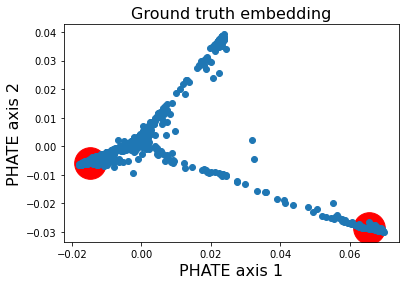

In [139]:
#Visualization of start and end point on embedding
plt.figure()
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(phatepredmet[sortind[900],0],phatepredmet[sortind[900],1],c='red',s=1000)
plt.scatter(phatepredmet[sortind[-50],0],phatepredmet[sortind[-50],1],c='red',s=1000)
plt.scatter(phatepredmet[:,0],phatepredmet[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


In [16]:
# Assign start and end points based on visualization 

rint=sortind[900]
mint=sortind[-50]
x0 = torch.tensor(ipsc_data[rint,None,:]).cpu()
x1 = torch.tensor(ipsc_data[mint,None,:]).cpu()


/tmp/ipykernel_221059/170773575.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(ipsc_data[rint,None,:]).cpu()
/tmp/ipykernel_221059/170773575.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(ipsc_data[mint,None,:]).cpu()


# Train NeuralODE

In [213]:

#First training step to ensure prediction is close to starting point

for it in range(150):
    opt.zero_grad()
    _, out = aug_node(x0, torch.linspace(0, 1, 5))
    pred = out[-1]  # batch, (1+dim)
    length, predx = pred[:, 0], pred[:, 1:]
    
    loss = 20 * torch.nn.MSELoss()(predx, x0) #+ torch.mean(length)
    if it % 50 == 0:
        print(loss.item())
    loss.backward()
    opt.step()
 

#Second trainign step to compute rest of trajectory
    
saveloss = []
for it in range(100):
    opt.zero_grad()
    _, out = aug_node(x0, torch.linspace(0, 1, 20))
    pred = out[-1]  # batch, (1+dim)
    length, predx = pred[:, 0], pred[:, 1:]
    len_loss = torch.mean(length)
    mse = torch.nn.MSELoss()(predx, x1)
    #loss = len_loss + 10*mse
    loss = 10*mse
    if it % 10 == 0:
        print(loss.item(), len_loss.item(), mse.item())
    saveloss.append(loss.item())
    loss.backward()
    opt.step()


np.save("saved_data/FIMloss_3_metric.npy",np.array(saveloss))
torch.save(net, "FIM_metric_geodesic_3_metric.pt")




/tmp/ipykernel_178435/3820564811.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metric = torch.tensor(fishermat).cuda()


1.0925310850143433
0.14132174849510193
0.01968132145702839
42.0915412902832 1.1960552001255564e-05 4.20915412902832
35.101158142089844 0.019168470054864883 3.5101158618927
27.192214965820312 0.0826759785413742 2.719221591949463
21.631080627441406 0.14880412817001343 2.1631081104278564
17.18644142150879 0.22328652441501617 1.718644142150879
13.3491792678833 0.31661728024482727 1.3349179029464722
10.07413101196289 0.4167594313621521 1.0074131488800049
7.389951705932617 0.521536648273468 0.7389951944351196
5.271000385284424 0.6376534104347229 0.5271000266075134
3.661048650741577 0.7416571974754333 0.3661048710346222


In [80]:

#np.save("saved_data/FIMloss_2_metric.npy",np.array(saveloss))
#torch.save(net, "FIM_metric_geodesic_2_metric.pt")

In [79]:
def computeJSD(X):
    
    #NOTE: Input for this function is matrix where the rows are log-transformed probabilites

    jsd = torch.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):

        p = X[i,:]
        q = X
        m = (0.5 * (p.exp() + q.exp()))
        

        kone = 0.5 *( (p.exp() * (p - m.log() ) ).sum(dim=1))
        ktwo = 0.5 *( (q.exp() * (q - m.log() ) ).sum(dim=1))
        k = kone + ktwo

        jsd[i,:] = k
     
    jsd.fill_diagonal_(0) #setting diagonal to 0 to avoid nan's
            
    return jsd.to('cuda')

In [58]:

#_, out = aug_node(x0, torch.linspace(0, 1, 11))

#Load data
n_obs=1500
traind = random.sample(range(0,X.shape[0]),n_obs)
ipsc_data, ipsc_emb = make_ipsc(n_obs=n_obs,emb_dim=2,knn=5,indx=traind)

#Ground truth embedding with subset of IPSC data
phate_op = phate.PHATE(random_state=42, verbose=False, knn=10,t=270).fit(ipsc_data.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()

gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )
mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_IPSC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())


Text(0, 0.5, 'PHATE axis 2')

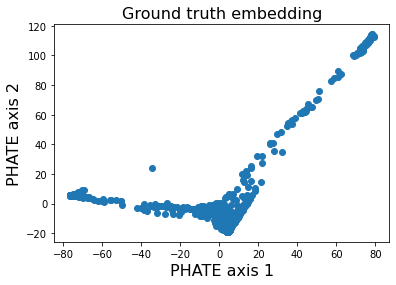

# Load NeuralODE models and compute geodesic

In [56]:

nomet = torch.load("FIM_metric_geodesic_2_nometric.pt")
met = torch.load("FIM_metric_geodesic_1.pt")



In [57]:
#Re-initialize points

x0 = torch.tensor(ipsc_data[rint,None,:]).cpu()
x1 = torch.tensor(ipsc_data[mint,None,:]).cpu()

print(x0.shape)
print(x1.shape)

torch.Size([1, 33])
torch.Size([1, 33])


/tmp/ipykernel_178435/3481240293.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(ipsc_data[rint,None,:]).cpu()
/tmp/ipykernel_178435/3481240293.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(ipsc_data[mint,None,:]).cpu()


In [214]:
#Define NeuralODE model

augmentations = AugmentationModule(fim_reg=1).cpu()
aug_net = AugmentedVectorField(net, augmentations.regs).cpu()
aug_node = Sequential(
    augmentations.augmenter, NeuralODE(aug_net, sensitivity="adjoint", solver="rk4")
)
aug_node

Sequential(
  (0): Augmenter()
  (1): Neural ODE:
  	- order: 1        
  	- solver: RungeKutta4()
  	- adjoint solver: RungeKutta4()        
  	- tolerances: relative 0.001 absolute 0.001        
  	- adjoint tolerances: relative 0.0001 absolute 0.0001        
  	- num_parameters: 12705        
  	- NFE: 0.0
)

In [17]:
# Compute geodesic

_, out = aug_node(x0, torch.linspace(0, 1, 20))
geodesic= out.squeeze()[:,1:]

/tmp/ipykernel_221059/3820564811.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metric = torch.tensor(fishermat).cuda()


In [18]:
print(geodesic.shape)
print(x0.shape)
print(x1.shape)

totalpathmet = np.concatenate((x0.cpu().detach().numpy(),geodesic.cpu().detach().numpy(),x1.cpu().detach().numpy()),axis=0)
#totalpathnomet = np.concatenate((x0.cpu().detach().numpy(),geodesic.cpu().detach().numpy(),x1.cpu().detach().numpy()),axis=0)



torch.Size([20, 33])
torch.Size([1, 33])
torch.Size([1, 33])


'\nprint(totalpath.shape)\n\n#Perform PCA and visualize\n\npca = PCA(n_components=3)\npca.fit(totalpath)\npcapred = totalpath @ pca.components_.T\nprint(pcapred.shape)\n\nplt.figure()\nplt.title("Geodesic learned (in red)")\nplt.xlabel("PCA axis 1")\nplt.ylabel("PCA axis 2")\n#plt.scatter(pcapred[0,0],pcapred[0,1],c=\'black\')\nplt.scatter(pcapred[:,0],pcapred[:,1],c=\'red\')\n#plt.scatter(pcapred[-1,0],pcapred[-1,1],c=\'black\')\n'

In [55]:
#Compute JSD embedding

#Ground truth embedding with subset of IPSC data
phate_op = phate.PHATE(random_state=42, verbose=False, knn=10,t=270).fit(pcapred)
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()

gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )
mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_IPSC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())


NameError: name 'computeJSD' is not defined

# Plotting geodesic with PHATE

In [19]:
print(totalpathmet.shape)
print(ipsc_data.shape)
orig_ipsc = ipsc_data.cpu().detach().numpy()
print(orig_ipsc.shape)

(22, 33)
torch.Size([1500, 33])
(1500, 33)


In [20]:

#concatenate original data with trajectory
totalmet = np.concatenate((orig_ipsc,totalpathmet),axis=0)


In [21]:
phatepredmet = phate.PHATE(random_state=42, n_components=3, verbose=False,t=250,decay=10).fit_transform(totalmet)
#phateprednomet = phate.PHATE(random_state=42, n_components=3, verbose=False).fit_transform(totalpathnomet)


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/graphtools/graphs.py:280: RuntimeWarning: Detected zero distance between samples 214 and 1500, 214 and 1501, 487 and 1521, 1500 and 1501. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


In [57]:

#Getting total length
lengthmet = outmet.squeeze()[0,0] - outmet.squeeze()[-1,0] 
lengthnomet = outnomet.squeeze()[0,0] - outnomet.squeeze()[-1,0]


torch.Size([20, 1, 34])
torch.Size([20, 1, 34])
tensor(-0.0004, grad_fn=<SubBackward0>)
tensor(-0.0007, grad_fn=<SubBackward0>)


# Plot geodesic

NameError: name 'phateprednomet' is not defined

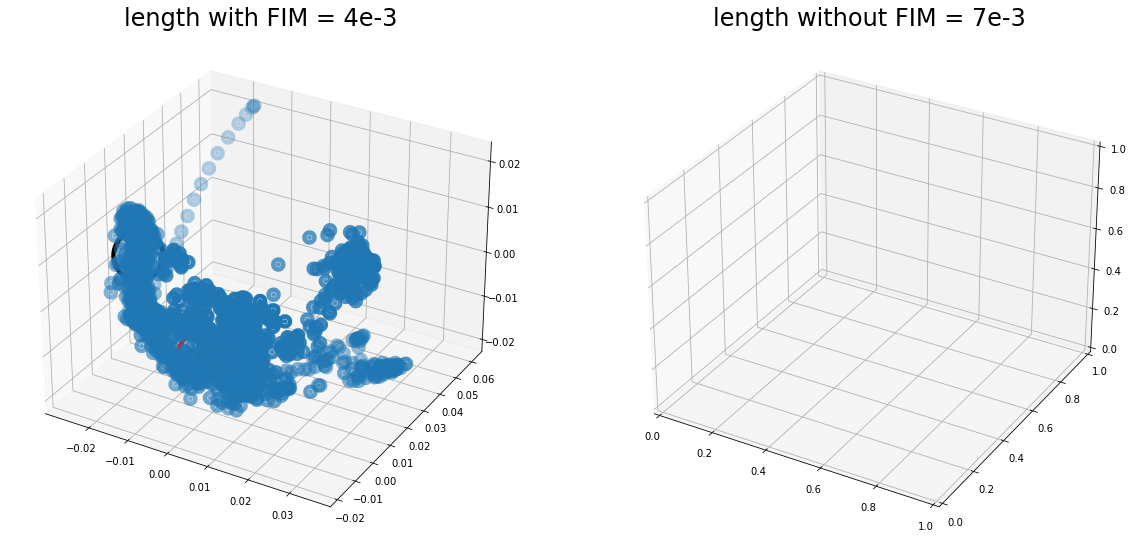

In [30]:

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.set_title("length with FIM = 4e-3",fontsize=24)
ax.scatter(phatepredmet[0,0],phatepredmet[0,1],phatepredmet[0,2],c='black',linewidth=50)
ax.scatter(phatepredmet[:,0],phatepredmet[:,1],phatepredmet[:,2],linewidth=10)
ax.scatter(phatepredmet[-1,0],phatepredmet[-1,1],phatepredmet[-1,2],c='red',linewidth=50)

ax = fig.add_subplot(1,2,2,projection='3d')
ax.set_title("length without FIM = 7e-3",fontsize=24)
ax.scatter(phateprednomet[0,0],phateprednomet[0,1],phateprednomet[0,2],c='black',linewidth=20)
ax.scatter(phateprednomet[:,0],phateprednomet[:,1],phateprednomet[:,2],linewidth=10)
ax.scatter(phateprednomet[-1,0],phateprednomet[-1,1],phateprednomet[-1,2],c='red',linewidth=20)

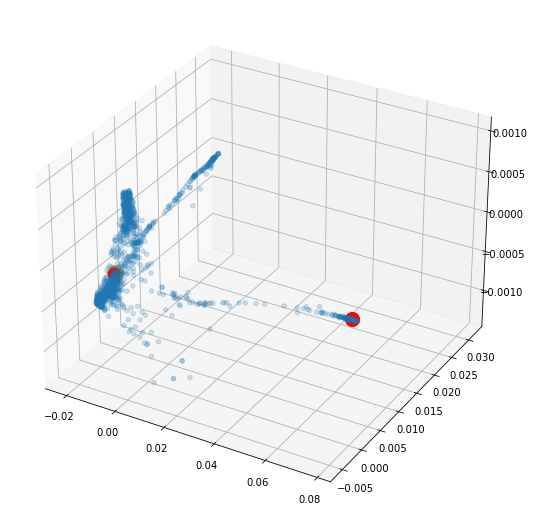

In [28]:


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1,projection='3d')
#ax.set_title("Geodesic (in red) on IPSC data",fontsize=24)
ax.scatter(phatepredmet[-22,0],phatepredmet[-22,1],phatepredmet[-22,2],c='orange',s=250)
ax.scatter(phatepredmet[:-22,0],phatepredmet[:-22,1],phatepredmet[:-22,2],alpha=0.2)
ax.scatter(phatepredmet[-22:-1,0],phatepredmet[-22:-1,1],phatepredmet[-22:-1,2],linewidth=1,c='red',s=100)
ax.scatter(phatepredmet[-1,0],phatepredmet[-1,1],phatepredmet[-1,2],c='red',linewidth=1,s=200)
#plt.savefig("geodesic.png")





In [175]:
np.save("geodesic_ipsc_two.npy",phatepredmet)

Text(0, 0.5, 'PHATE axis 1')

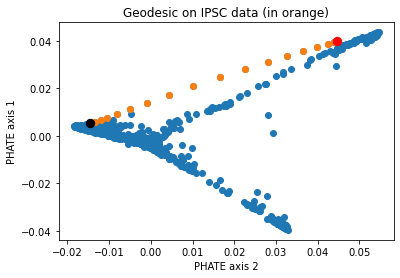

In [156]:
plt.figure()
plt.title("Geodesic on IPSC data (in orange)")
plt.scatter(phatepredmet[:,0],phatepredmet[:,1])
plt.scatter(phatepredmet[-22:,0],phatepredmet[-22:,1])
plt.scatter(phatepredmet[-1,0],phatepredmet[-1,1],c='red',s=70)
plt.scatter(phatepredmet[-22,0],phatepredmet[-22,1],c='black',s=70)
plt.xlabel("PHATE axis 2")
plt.ylabel("PHATE axis 1")